<a href="https://colab.research.google.com/github/oliv-ia/C3-segmentation/blob/main/2_model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Starting using pytorch
 From this guys video: https://www.youtube.com/watch?v=9aYuQmMJvjA

 and this guys: https://www.youtube.com/watch?v=lEtr9nnO5FI
 
 Helpful webpage on transfer learning for VGG16: https://debuggercafe.com/transfer-learning-with-pytorch/

Image segmentation using fcn resnet. Need to classify pixels as muscle or not_muscle.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#import SimpleITK as sitk
import numpy as np
import os
from scipy import ndimage
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 245kB 38.7MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=54304f494cba190e98b559b6a1b68923c6fd8603860e7850a95d307f7161a349
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=8d2edfea95556c07e772f0f4fba1b710a3ff60f70ad62754c8255aee3732f702
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
!pip install torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import segmentation_models_pytorch as smp
from PIL import Image
import time
from __future__ import division
import copy
%load_ext tensorboard
from tqdm import tqdm
import sklearn

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 986924332717784181, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13812874624
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6353984298616085222
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

#Useful definitions

getting the learning rate

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#Loading the training data from a python dictionary.

In [ ]:
data = np.load("/content/training_data_h_38_cropped.npz", allow_pickle=True)
slices = data['slices']
masks = data['masks']
ids = data['ids']
#data_a = np.load("/content/training_data_h_38_area.npz", allow_pickle=True)
#areas = data_a['pixel_areas']

In [ ]:
[*data.keys()]

['slices', 'masks', 'ids']

In [ ]:
print(areas)

[0.87890625 0.95367432 0.95367432 0.87890625 0.95366943 0.95366943
 0.87890625 0.95367339 0.87890625 0.95366943 0.95366943 0.95366943
 0.95366943 0.95367432 0.95366943 0.95366943 0.87890625 0.95366943
 0.95367432 0.95367432 0.95367432 0.95367432 0.95367339 0.87890625
 0.87890625 0.87890625 0.95367432 0.95367432 0.87890625 0.87890625
 0.87890625 0.87890625 0.95367432 0.4673005  0.95367432]


#Preprocessing


Set the window and level here. 50:350HU for soft tissue

In [ ]:
def preprocess(slice_array, masks_array):
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  window = 350
  level = 50
  size = len(masks_array)
  vmin = (level/2) - window
  vmax = (level/2) + window
  processed_slices = []
  processed_masks = (np.nan_to_num(masks_array)).astype(np.float64)
  for i in range (0, size):
    slice_array[i][slice_array[i]>vmax] = vmax
    slice_array[i][slice_array[i]<vmin] = vmin
    shape = slice_array[i].shape
    image_scaled = np.round(sklearn.preprocessing.minmax_scale(slice_array[i].ravel(), feature_range=(0,1)), decimals = 10).reshape(shape)
    processed_slices.append(image_scaled)
    processed_masks[i][processed_masks[i]>1] = 1
  processed_slices = np.array(processed_slices)
  return processed_slices, processed_masks

In [ ]:
slices_processed, masks_processed = preprocess(slices, masks)
print(slices_processed[0].min(), slices_processed[0].max())
print(masks_processed[0].min(), masks_processed[0].max())
print(slices_processed.shape)
print(masks_processed.shape)

0.0 1.0
0.0 1.0
(35, 260, 260)
(35, 260, 260)


#Split the data

split into train, val and test data

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

(25, 260, 260)
01-0034


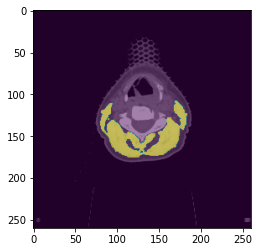

In [ ]:
slice_train, slice_test, masks_train, masks_test, ids_train, ids_test = train_test_split(slices_processed, masks_processed, ids, test_size=(10/35), random_state = 5)
slice_test, slice_val, masks_test, masks_val, ids_test, ids_val = train_test_split(slice_test, masks_test, ids_test, test_size = 0.5, random_state = 5 )

print(slice_train.shape)
plt.imshow(slice_test[3,:,:], cmap = 'gray')
plt.imshow(masks_test[3],alpha = 0.5)
print(ids_test[1])

work out the average ratio of segmented pixels to background in our training masks.

In [ ]:
#ratio of no of 1s over no of 0s. averaged
ratio = []
for i in range(len(masks_train)):
  no_of_0s = (masks_train[i] == 0).sum()
  no_of_1s = (masks_train[i] == 1).sum()
  #print(no_of_1s, no_of_0s)
  ratio.append(no_of_1s/no_of_0s)

average_ratio = np.mean(ratio)
print(average_ratio)
weights = (1/average_ratio) #*10 to penalise the network more harshly for getting it wrong
weight = torch.Tensor([weights])
print(weight)

0.07733608289205438
tensor([12.9306])


#Transform the data

Apply the transformations needed

In [ ]:
import torchvision.transforms as T

In [ ]:
def genTransforms(slice_array, masks_array):
  transform_slices = []
  transform_masks = []
  size = len(masks_array)
  #masks = masks_array[:,np.newaxis,:,:]
  if slice_array.shape != (size,3,...):
    slices_3chan = np.repeat(slice_array[:,:,:,np.newaxis], 3, axis=-1)
    #slice_array = np.moveaxis(slices_3chan, 3,1)
  transform_slice = slices_3chan.astype(np.float32)
  transform_mask = masks_array.astype(np.float32)
  #print("maybe here?",transform_mask.shape)
  return transform_slice, transform_mask

In [ ]:
def transforms(slice_array, masks_array):
  trf = T.Compose([T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  transform_slices = []
  transform_masks = []
  size = len(slice_array)
  masks = masks_array[:,np.newaxis,:,:]
  if slice_array.shape != (size,3,...):
    slices_3chan = np.repeat(slice_array[:,:,:,np.newaxis], 3, axis=-1)
    slice_array = np.moveaxis(slices_3chan, 3,1)
  for i in range(0,size):
    transform_slices.append(np.array(trf(torch.from_numpy(slice_array[i]))))
    transform_masks.append(np.array(torch.from_numpy(masks[i])))
  transform_slice = np.array(transform_slices)
  transform_mask = np.array(transform_masks)
  slices_inp = torch.from_numpy(transform_slice.astype(np.float32))
  masks_inp = torch.from_numpy(transform_mask.astype(np.float32))
  return slices_inp, masks_inp

#Data augmentation

https://colab.research.google.com/github/albumentations-team/albumentations_examples/blob/colab/pytorch_semantic_segmentation.ipynb
really useful link for the general pipeline overveiw

In [ ]:
import albumentations as A
import random
from albumentations.pytorch import ToTensor

In [ ]:
train_transform = A.Compose([
  A.Resize(260, 260),
  A.RandomSizedCrop(min_max_height=(200, 260), height=260, width=260, p=0.2),
  A.HorizontalFlip(p=0.5),
  A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, p=0.5),
  A.ElasticTransform(alpha=120, sigma=120 * 0.8, alpha_affine=120 * 0.05, p= 0.2),
  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
  ToTensor()
])

val_transform = A.Compose(
    [A.Resize(260, 260), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensor()]
)

test_transform = A.Compose(
    [A.Resize(260, 260), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensor()]
)

Convert make a dataset and dataloader. Need a custom dataset to apply the augmentations on the go. Means we end up with more data when run on lots of epochs.

In [ ]:
class H_custom_Dataset(TensorDataset): #like this but livs
    def __init__(self, images, masks, transform=None):
        super(H_custom_Dataset, self).__init__() #dont know what this does find out
        self.transform = transform
        self.images, self.masks  = genTransforms(images, masks)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      if self.transform:
        augmentations = self.transform(image=self.images[idx], mask=self.masks[idx])
        image = augmentations["image"]
        mask =augmentations["mask"]
      else:
        image = self.images
        mask = self.masks
      return image, mask

In [ ]:
train_dataset = H_custom_Dataset(slice_train, masks_train, transform = train_transform)#transforms = aug
test_dataset = H_custom_Dataset(slice_test, masks_test, transform = test_transform)
val_dataset = H_custom_Dataset(slice_val, masks_val, transform = val_transform)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, num_workers = 2, shuffle = True)#used batch size 4 for sem1
test_dataloader = DataLoader(test_dataset, batch_size = len(slice_test), num_workers = 2, shuffle = False)
val_dataloader = DataLoader(val_dataset, batch_size = 8, num_workers = 2, shuffle = True)

#Tensorboard
a nice way of displaying the data and how the model is progressing

In [ ]:
for batch_idx, train_dataset in enumerate(train_dataloader):
      slice_train, masks_train = train_dataset[0], train_dataset[1]    
      fig=plt.figure(figsize=(15, 15))
      ax = []
      #figure with 5 columns
      for i in range(0, len(slice_train)):
        ax.append(fig.add_subplot(1, 5, i+1))
        plt.imshow(slice_train[i,0], cmap="Greys")
        plt.imshow(masks_train[i,0], alpha = 0.5)
        ax[-1].set_title("test:"+str(i))
      plt.show()
      #break

torch.Size([8, 3, 260, 260])
torch.Size([8, 1, 260, 260])
torch.Size([3, 264, 2098])
torch.Size([3, 264, 2098])


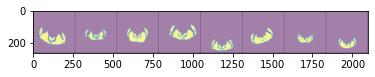

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter()
# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)
# show images
img_grid = torchvision.utils.make_grid(images)
lab_grid = torchvision.utils.make_grid(labels.squeeze(0))
plt.imshow(img_grid[0], cmap="Greys")
#show(img_grid)
plt.imshow(lab_grid[0], alpha = 0.5)
print(img_grid.shape)
print(lab_grid.shape)
# write to tensorboard
writer.add_image('four_train_images', img_grid)
writer.add_image('four_masks', lab_grid)

#Modifying the model
Pick the model and edit it. Change the number of classifiers and freeze the weights

Donal's way - to load the pretained model and the untrained one with different classes and compare them to build ours.

In [ ]:
# Load pre-trained model
pt_model = models.segmentation.fcn_resnet50(pretrained=True)
model = models.segmentation.fcn_resnet50(pretrained=False, num_classes=1)
# Change final layer as pre-trained model expects 21 outputs
pt_dict = pt_model.state_dict()
model_dict = model.state_dict()
pretrained_dict = {}
for key, val in pt_dict.items():
    if key in model_dict:
        if val.shape == model_dict[key].shape:
            pretrained_dict[key] = val
        else:
            print("Shapes don't match")
            continue
    else:
        print("key not in dict")
        continue
# Overwrite entries in the existing state dict
model_dict.update(pretrained_dict)
# Load new state dict
model.load_state_dict(model_dict)
#print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth



Shapes don't match
Shapes don't match
key not in dict
key not in dict
key not in dict
key not in dict
key not in dict
key not in dict
key not in dict
key not in dict


<All keys matched successfully>

optimiser and criterion

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)#lr=args.pre_train_lr
#optimizer = optim.Adadelta(model.parameters(), lr=0.01, weight_decay= 1)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weight).cuda()
# Decay LR by a factor of 0.5 every 2 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

In [ ]:
#print(model)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Can save the model weights to be loaded later if you want here.

In [ ]:
# initialize the model class before loading the model
#model = TheModelClass()
# load the model
#model.load_state_dict(torch.load(/content/model_state_dict))
# Load pre-trained model
model = models.segmentation.fcn_resnet50(pretrained=False, num_classes=1)
path = "/content/model_state_dict_300_epochs_2.pt"
model.load_state_dict(torch.load(path, map_location="cuda:0"))

model.to(torch.device('cuda'))

#Train and validation functions. 
https://www.pluralsight.com/guides/introduction-to-resnet <- might help a bit later

In [ ]:
# training function
def train(model, train_dataloader, device):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    total_step = len(train_dataloader)
    for batch_idx, train_dataset in enumerate(train_dataloader):
        slice_train, masks_train = train_dataset[0].to(device), train_dataset[1].to(device)
        slice_train = slice_train.type(torch.float32)
        optimizer.zero_grad()
        output = model(slice_train)
        loss = criterion(output["out"], masks_train)
        #writing to tensorboard
        #writer.add_scalar('training loss',
         #                   loss,
          #                  epoch * len(train_dataloader) + batch_idx)
        #writer.add_images("slices", slice_train)
        test_output_1 = output["out"].detach().cpu()
        sigmoid = 1/(1 + np.exp(-test_output_1))
        segment_pred = (sigmoid > 0.5).float()
        writer.add_images("predictions", segment_pred)
        #print("loss: ", loss)
        #acuracy
        train_running_loss += loss.item()
        _, preds = torch.max(output["out"], 1)#["out"]
        train_running_correct += (preds == masks_train).sum().item()
        loss.backward()
        optimizer.step()
    #what actually is this    
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = train_running_correct/len(train_dataloader.dataset)
    writer.add_scalar('training loss',
                            train_loss,
                            epoch)#.dataset?
    #print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [ ]:
def validate(model, val_dataloader, device):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(val_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        data = data.type(torch.float32)
        #target.cuda()
        output = model(data)
        #print("output shape: ", output["out"].shape)
        loss = criterion(output["out"], target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output["out"], 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(val_dataloader.dataset)
    #writing to tensorboard
    writer.add_scalar('Validation loss',
                            val_loss,
                            epoch)
    val_accuracy = val_running_correct/len(val_dataloader.dataset)
    
    return val_loss, val_accuracy

In [ ]:
def test(model, test_dataloader):
    model.eval()
    test_running_loss = 0.0
    test_running_correct = 0
    segments = []
    predictions = torch.Tensor()
    for int, data in enumerate(test_dataloader):
        slices_test = data[0].to(device)
        slices_test = slices_test.type(torch.float32)
        output = model(slices_test)
        print("output shape: ", output["out"].shape)
        test_ouput = output["out"].detach().cpu()
        sigmoid = 1/(1 + np.exp(-test_ouput))
        segment = (sigmoid > 0.6).float()
        print(segment.shape())
        segments.append(np.array(segment))
        #_, preds = torch.max(output["out"], 1)
        #print(preds.shape)
        #segments = (preds > 0.5).float()
        #val_running_correct += (preds == target).sum().item()
    
    #val_loss = val_running_loss/len(val_dataloader.dataset)
    #val_accuracy = val_running_correct/len(val_dataloader.dataset)
    segments = np.array(segments)
    return segments

another training function from this webpage:https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
Can use it when you want to make stuff more streamlined/complicated

Checking memory space

In [ ]:
!nvidia-smi

Sun Jan  3 16:06:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |    927MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Training the model

Train over 10 epochs. doesnt like the input shape.



In [ ]:
!pip install pytorchtools

In [ ]:
def Compare(list, number):
  counter = False
  index = len(list)
  for i in range (0,index):
    if number <= list[i]:
      counter = True
  return counter

In [ ]:
val_last_ten = []
def last_ten():
  for i in range(1,11):
    val_last_ten.append(val_loss[epoch - i])
  return val_last_ten

In [ ]:
# import EarlyStopping
from pytorchtools import EarlyStopping

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
num_epochs = 300
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print("\nlearning rate: ", get_lr(optimizer))
  #tk0 = tqdm(epoch, total=num_epochs)
  train_epoch_loss, train_epoch_accuracy = train(model, train_dataloader, device)
  val_epoch_loss, val_epoch_accuracy = validate(model, val_dataloader, device)
  #if epoch > 200:
   # if Compare(last_ten(), val_epoch_loss) == False:
    #  end = time.time()
     # print((end-start)/60, 'minutes')
      #print( "Early Stopping after ", epoch, " epochs"  )
      #print("val_epoch_loss = " , val_epoch_loss, "Val_last ten: ", val_last_ten)
      #break
  train_loss.append(train_epoch_loss)
  train_accuracy.append(train_epoch_accuracy)
  print("train loss: ", train_loss) 
  #print() "train acc: ", train_accuracy)
  val_loss.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)
  print("val loss: ",val_loss) 
  #print("val acc: ", val_accuracy)
  scheduler.step()

end = time.time()
print((end-start)/60, 'minutes')

Where you can veiw it

In [ ]:
%tensorboard --logdir=runs

Saving the retrained model weights for anonther time.

In [ ]:
# save the model state_dict
torch.save(model.cuda().state_dict(), "/content/model_state_dict_300_epochs_v3.pt")

#Testing the model
Displaying the models segment

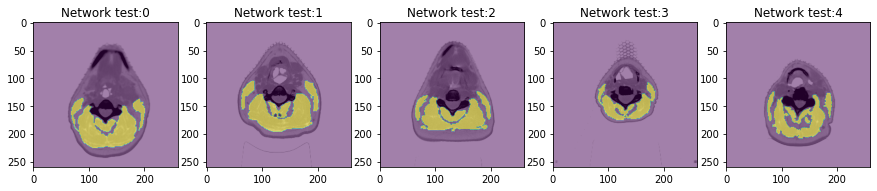

torch.Size([5, 3, 260, 260])


In [ ]:
for batch_idx, test_dataset in enumerate(test_dataloader):
      test_em, test_lab = test_dataset[0], test_dataset[1]    
      break
#figure with 5 columns
fig=plt.figure(figsize=(15, 15))
ax = []
for i in range(0, len(test_em)):
  ax.append(fig.add_subplot(1,5, i+1))
  #test_lab[i][test_lab[i]==0] = np.nan
  plt.imshow(test_em[i,0,...], cmap="Greys")
  plt.imshow(test_lab[i,0,...], alpha = 0.5)
  ax[-1].set_title("Network test:"+str(i))
  #plt.axis('off')
plt.show() 
print(test_em.shape)

In [ ]:
model.eval()
test_output = model((test_em.cuda().type(torch.float32)))["out"]
print(test_output.shape)

torch.Size([5, 1, 260, 260])


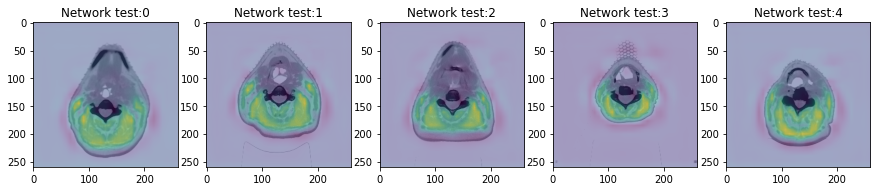

In [ ]:
test_output_1 = test_output.detach().cpu()
fig=plt.figure(figsize=(15, 15))
ax = []
for i in range(0, len(test_em)):
  ax.append(fig.add_subplot(1,5, i+1))
  plt.imshow(test_em[i,0,...], cmap="Greys")
  plt.imshow(test_output_1[i,0,...], alpha = 0.5)
  ax[-1].set_title("Network test:"+str(i))
plt.show()

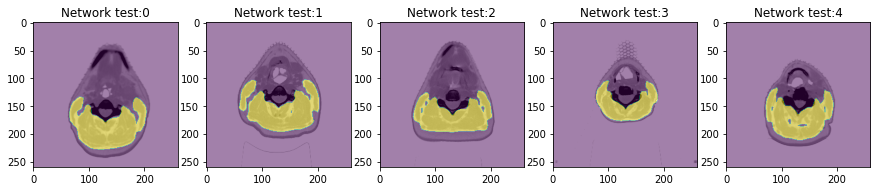

In [ ]:
sigmoid = 1/(1 + np.exp(-test_output_1))
segment_pred = (sigmoid > 0.5).float()
fig=plt.figure(figsize=(15, 15))
ax = []
for i in range(0, 5):
  ax.append(fig.add_subplot(1,5, i+1))
  plt.imshow(test_em[i,0,...], cmap="Greys")
  plt.imshow(segment_pred[i,0,...],  alpha = 0.5)
  #plt.imshow(test_lab[i,0,...], alpha= 0.5)
  ax[-1].set_title("Network test:"+str(i))
  #plt.axis("off")
plt.show()

#Compare out Network's output with our segments
Do Dice between the networks sigmoided output and our segments.
Also do Dice between thresholded output and sigmoid and ours

Liv's dice eval function that she found on the internet (get link)

In [ ]:
def diceCoeff(pred, gt, smooth=1, activation='sigmoid'):
    """ computational formula：
        dice = (2 * (pred ∩ gt)) / (pred ∪ gt)
    """
    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = nn.Softmax2d()
    else:
        raise NotImplementedError("Activation implemented for sigmoid and softmax2d activation function operation")
 
    pred = np.round(activation_fn(pred))
    N = gt.size(0) #n should be batch size
    pred_flat = pred.view(N, -1)
    gt_flat = gt.view(N, -1)
 
    intersection = (pred_flat * gt_flat).sum(1)
    unionset = pred_flat.sum(1) + gt_flat.sum(1)
    print(intersection, unionset)
    loss = (2 * intersection + smooth) / (unionset + smooth)
 
    return loss.sum() / N

In [ ]:
dice_array = []

dice_net_v_pred = diceCoeff(test_lab, segment_pred , smooth=1, activation=None)

print("dice_net_v_pred", dice_net_v_pred)
mean = np.mean(dice_net_v_pred.item())

print(mean)

tensor([6223., 6265., 5177., 2715., 4358.]) tensor([14993., 15127., 12854.,  7664., 12010.])
dice_net_v_pred tensor(0.7797)
0.779656708240509


#Area and Density of the Predictions

Calculate the area of the segment and get the muscel density in this area. make sure to use the unnormalised ct scans.

In [ ]:
ct_scans = np.array(slice_test)
#network_pred = segment_pred[:,0,...]

In [ ]:
print(ct_scans.shape, segment_pred.shape)

In [ ]:
from functools import partial

In [ ]:
def getDensity(image, mask, area, label=1):#pixel density
  if image.shape != (len(image),1,...):
    mask = np.squeeze(mask)
  # remove image.data since passing array
  return float(np.mean(image[np.where(mask == 1)]))#-1024

pixel area for each of my data bits. need to make sure they match up maybe add to array with identities.

In [ ]:
pix_area = [0.87890625, 0.95367431640625, 0.95367431640625, 0.87890625, 0.9536694269690003, 0.9536694269690003, 0.87890625, 0.9536733850839028, 0.87890625, 0.9536694269690003, 0.9536694269690003, 0.9536694269690003, 0.9536694269690003, 0.95367431640625, 0.9536694269690003, 0.9536694269690003, 0.87890625, 0.9536694269690003, 0.95367431640625, 0.95367431640625, 0.95367431640625, 0.95367431640625, 0.9536733850839028, 0.87890625, 0.87890625, 0.87890625, 0.95367431640625, 0.95367431640625, 0.87890625, 0.87890625, 0.87890625, 0.87890625, 0.95367431640625, 0.46730049652979133, 0.95367431640625]
#mm^2
pixel_area = np.array(pix_area)*(0.1*0.1) #cm^2
print(pixel_area)

In [ ]:
a = (0.09375*0.09375)  #area of 1 pixel cm^2
def getArea(image, mask, area, label=1, thresholds = None):
  sMasks = (mask == label)
  threshold = np.logical_and(image > (thresholds[0]), image <  (thresholds[1]))
  tmask = np.logical_and(sMasks, threshold)
  #np.count_nonzero(tmask)
  return np.count_nonzero(tmask) * area

In [ ]:
density = getDensity(ct_scans[2], segment_pred[2], pix_area[2])
print(density)

0.4807532746307115


In [ ]:
print(ids_test)

['01-0023' '01-0034' '01-0026' '01-001' '01-0019']


In [ ]:
pixel_area_id = [pixel_area[23-1],pixel_area[34-1],pixel_area[26-1],pixel_area[1-1],pixel_area[19-1]]
pixel_area_id = np.array(pixel_area_id)
print(pixel_area_id)


[0.00953673 0.004673   0.00878906 0.00878906 0.00953674]


In [ ]:
## Note that the areas have some thresholds applied that are from the literature
extractionDict = {"sma" : partial(getArea, thresholds=(-30, +130)), 
				  "smd" : partial(getDensity)
				 }
feat_list_1 = ["sma","smd"]
feat_list_2 = ["sma","smd"]
# Extract features from slices_processed
feature_list_net = []
feature_list_ours = []
for i in range(0,len(ct_scans)):
  feature_list_net.append([extractionDict[a](ct_scans[i], segment_pred[i], pixel_area_id[i]) for a in feat_list_1])
  feature_list_ours.append([extractionDict[a](ct_scans[i], test_lab[i], pixel_area_id[i]) for a in feat_list_2])

In [ ]:
print("Area, Density of nets predictions", feature_list_net)
print("Area, Density of ours", feature_list_ours)

Area, Density of nets predictions [[68.38769531250001, 0.48918115556224134], [73.8811492919922, 0.5042486492467536], [66.29943847656251, 0.5036560907438147], [38.75732421875001, 0.5010840832402559], [65.20271301269533, 0.493526191521018]]
Area, Density of ours [[54.826171875000014, 0.5135760087944052], [60.272216796875014, 0.5261564195299684], [49.59106445312501, 0.5357057692300192], [25.901794433593754, 0.5251451714715758], [42.09518432617188, 0.5289737199825328]]


#Sarcopenia Value

Looking at the skeletal muscle area. SMI.

In [ ]:
#smas = [f[0] for f in feature_list] #list way of doing it
#for the network
sma = np.array(feature_list_net)[:,0]
mean_area = np.mean(sma)
area_sd = ndimage.standard_deviation(sma)
print(mean_area, "cm^2 ", "sd: ", area_sd)

62.50566406250001 cm^2  sd:  12.244593896991116


In [ ]:
#for our segments
sma_ours = np.array(feature_list_ours)[:,0]
mean_area_ours = np.mean(sma_ours)
area_sd_ours = ndimage.standard_deviation(sma_ours)
print(mean_area_ours, "cm^2 ", "sd: ", area_sd_ours)

40.138588043677714 cm^2  sd:  12.54094648353225


skeletal muscle density SMD

In [ ]:
smd = np.array(feature_list_net)[:,1]#sm attenuation
mean_density = np.mean(smd)
den_sd = ndimage.standard_deviation(smd)
print(mean_density, "HU" ,"sd", den_sd)

In [ ]:
smd_ours = np.array(feature_list_ours)[:,1]#sm attenuation
mean_density_ours = np.mean(smd_ours)
den_sd_ours = ndimage.standard_deviation(smd_ours)
print(mean_density_ours, "HU" ,"sd", den_sd_ours)

0.5259114178017004 HU sd 0.007184935479330131


times them together?

In [ ]:
sarc = mean_area*mean_density
sarc_ours = mean_area_ours*mean_density_ours
print("sarc nets: ", sarc, "unctertainty", sarc*((area_sd/mean_area)+(den_sd/mean_density)))
print("sarc ours: ", sarc_ours, "unctertainty",sarc_ours*((area_sd_ours/mean_area_ours)+(den_sd_ours/mean_density_ours)))

sarc nets:  31.14902475349398 unctertainty 6.474654814582298
sarc ours:  24.474490259147178 unctertainty 6.611182612294491
